In [1]:
import skysurvey
import matplotlib.pyplot as plt
import numpy as np
import sncosmo
from scipy.ndimage import gaussian_filter
from scipy.spatial import cKDTree
import corner
import pandas
from code import *

In [2]:
import warnings
from iminuit.warnings import IMinuitWarning
warnings.filterwarnings('ignore', category=IMinuitWarning) 

# skysurvey tests

In [12]:
snia = skysurvey.SNeIa()

In [13]:
data = snia.draw(size=10_000, inplace=True)

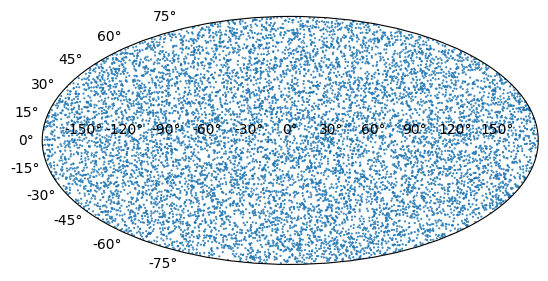

In [14]:
fig = plt.figure()
ax = fig.add_subplot(projection="mollweide")
ax.scatter(
    (snia.data["ra"] - 360 * (snia.data["ra"] > 180)) * np.pi / 180,
    snia.data["dec"] * np.pi / 180,
    linestyle="",
    marker=".",
    s=1,
)

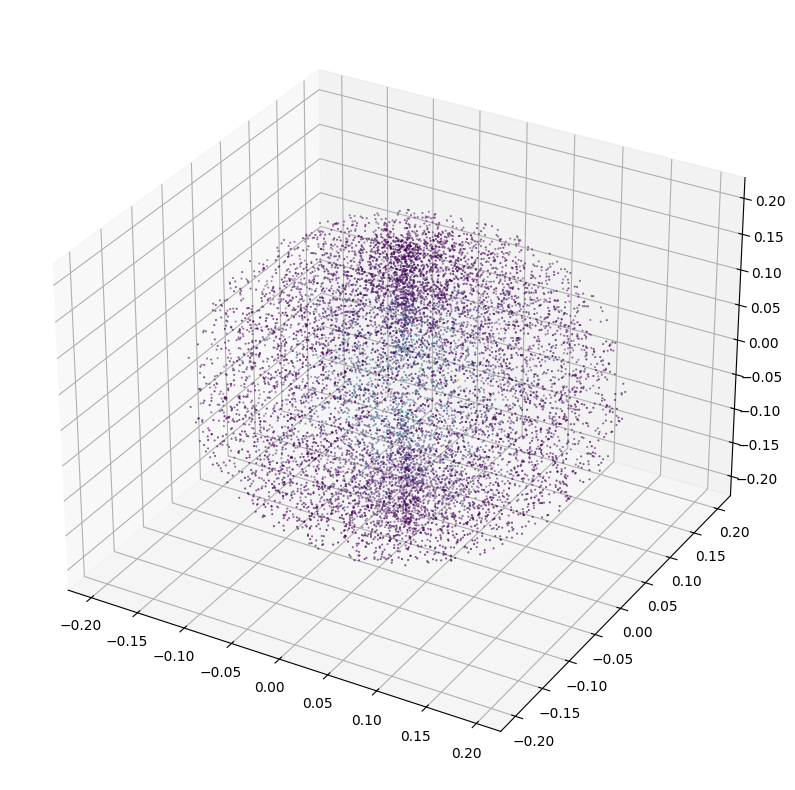

In [15]:
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection="3d"))

count, bin = np.histogramdd([snia.data["ra"], snia.data["dec"], snia.data["z"]], bins=50)
count = gaussian_filter(count, 0.9)
binra, bindec, binz = bin
x, y, z = np.meshgrid(
    (binra[:-1] + binra[1:]) / 2 - binra.min(),
    (bindec[:-1] + bindec[1:]) / 2 - bindec.min(),
    (binz[:-1] + binz[1:]) / 2 - binz.min(),
)
tree = cKDTree(np.dstack((x.flatten(), y.flatten(), z.flatten())).reshape(-1, 3))
pts = np.vstack(
    [snia.data["ra"] - binra.min(), snia.data["dec"] - bindec.min(), snia.data["z"] - binz.min()]
).T


def density_tree(
    pts: np.ndarray, tree: cKDTree, density: np.ndarray, k=1
) -> np.ndarray:
    dist_id, nn_id = tree.query(pts, k=k)
    try:
        density = np.average(density[nn_id], axis=1, weights=1 / dist_id)
    except np.AxisError:
        density = density[nn_id]
    return density


c = density_tree(
    pts, tree, np.transpose(count, axes=[1, 0, 2]).flatten()[::-1], k=1
)

ax.scatter(
    np.cos(snia.data["ra"]) * np.sin(snia.data["dec"]) * snia.data["z"],
    np.sin(snia.data["ra"]) * np.sin(snia.data["dec"]) * snia.data["z"],
    np.cos(snia.data["dec"]) * snia.data["z"],
    s=1,
    c=c,
    marker=".",
)

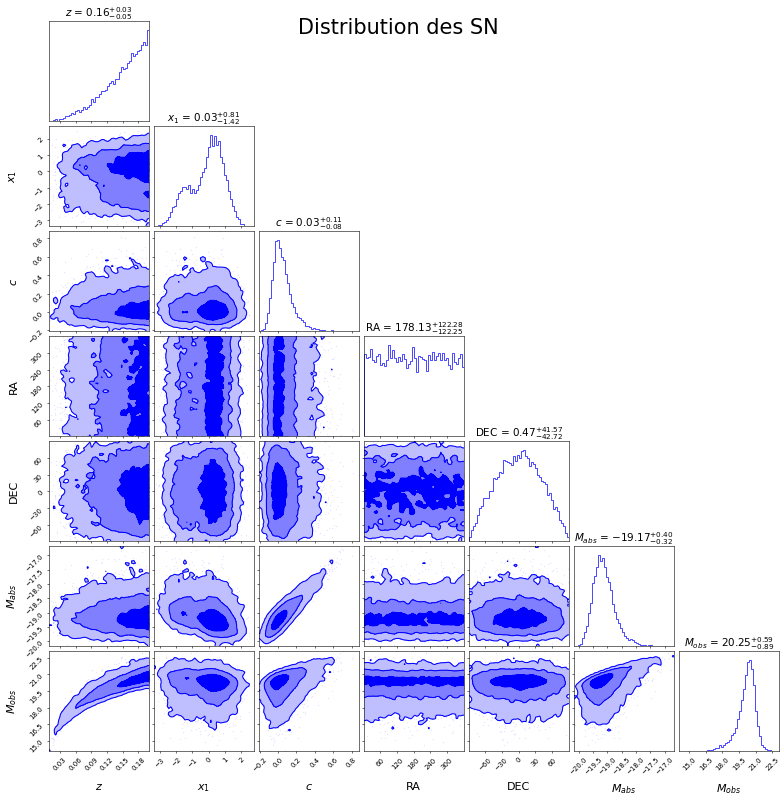

In [17]:
fig = corner_(
    snia.data,
    var_names=["z", "x1", "c", "ra", "dec", "magabs", "magobs"],
    labels=[r"$z$", r"$x_1$", r"$c$", r"RA", r"DEC", r"$M_{abs}$", r"$M_{obs}$"],
    title='Distribution des SN',
)

In [18]:
# footprint
from shapely import geometry

footprint = geometry.Point(0, 0).buffer(2)

# observing logs
from skysurvey.tools import utils

size = 10_000

data = {}
data["gain"] = 1
data["zp"] = 30
data["skynoise"] = np.random.normal(size=size, loc=200, scale=20)
data["mjd"] = np.random.uniform(56_000, 56_200, size=size)
data["band"] = np.random.choice(["ztfg", "ztfr", "ztfi"], size=size)

data["ra"], data["dec"] = utils.random_radec(
    size=size, ra_range=[200, 250], dec_range=[-20, 10]
)

# Load a GridSurvey
survey = skysurvey.Survey.from_pointings(data, footprint=footprint)

In [25]:
import pickle

with open('../data/ztf_survey.pkl','rb') as file:
    survey = pickle.load(file)

In [40]:
dset = skysurvey.DataSet.from_targets_and_survey(snia, survey)

/global/homes/a/agillesl/.local/perlmutter/python-3.11/lib/python3.11/site-packages/ztffields/projection.py:151: UserWarning: you don't have dask-geopandas, you have more than 20_000 fields, this would be faster with dask-greopandas
  warnings.warn("you don't have dask-geopandas, you have more than 20_000 fields, this would be faster with dask-greopandas")
/global/homes/a/agillesl/.local/perlmutter/python-3.11/lib/python3.11/site-packages/skysurvey/dataset.py:154: FutureWarning: The behavior of pd.concat with len(keys) != len(objs) is deprecated. In a future version this will raise instead of truncating to the smaller of the two sequences
  data = pandas.concat(lightcurves, keys=fieldids # store fieldid


In [128]:
dataset = dset.get_ndetection() > 5
detected = dataset[dataset].index

In [130]:
len(detected)

360

Text(0.5, 0.98, 'Distribution des SN détectées')

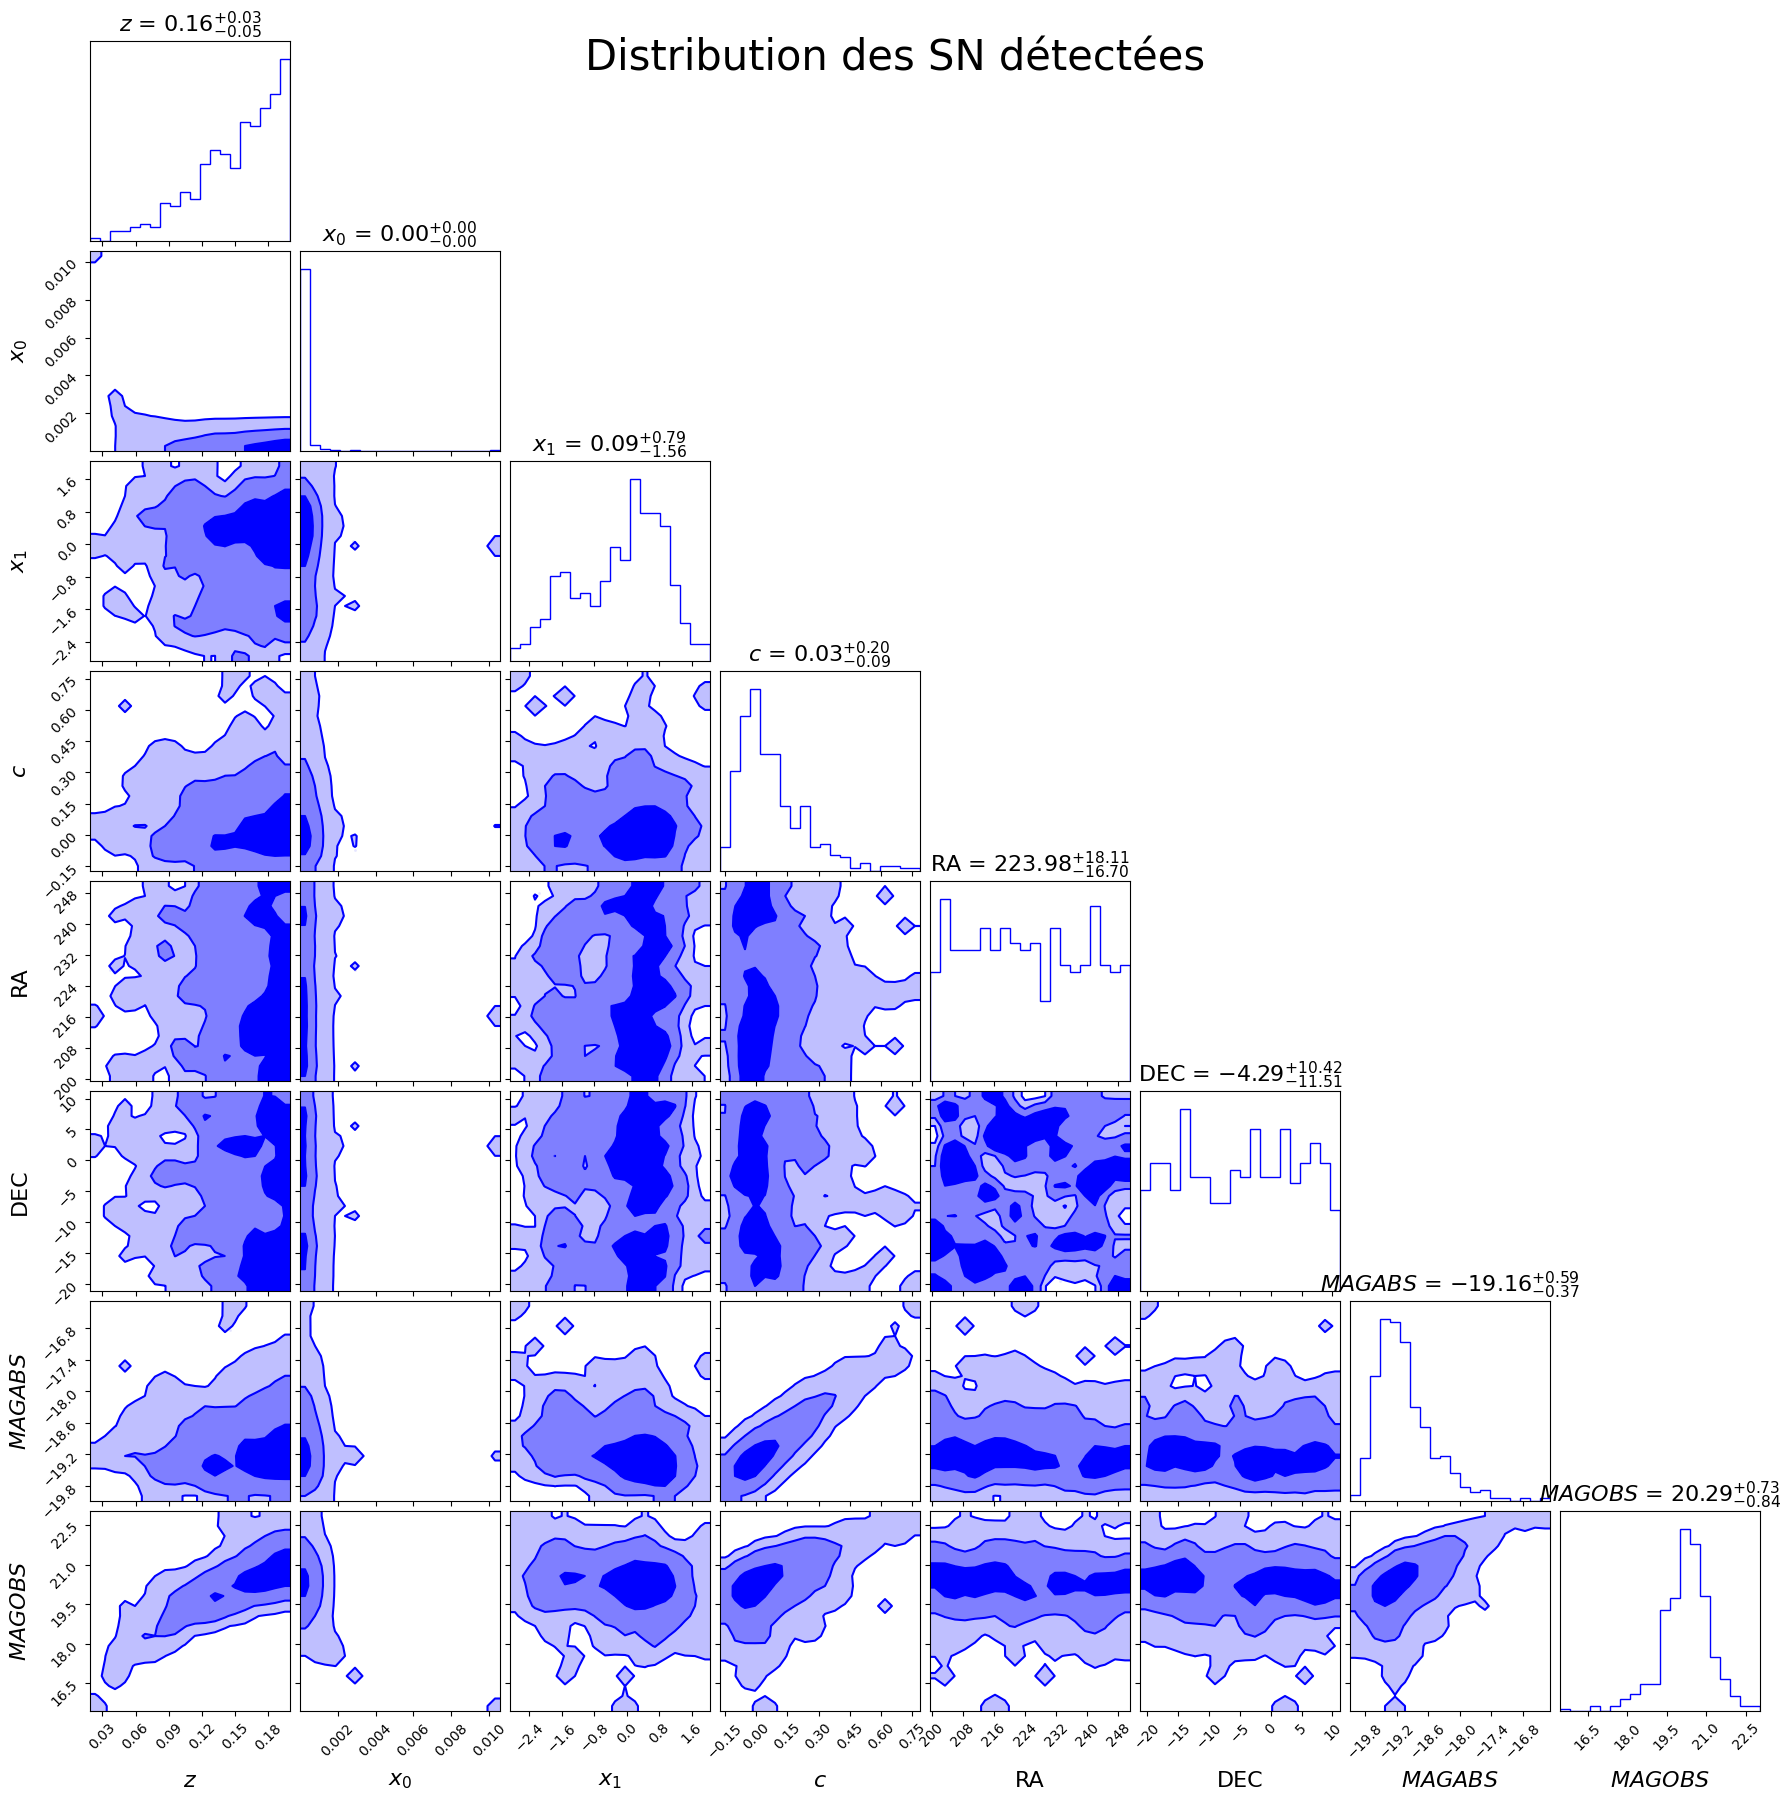

In [81]:
fig = corner.corner(
    dset.targets.data.loc[detected],
    var_names=["z", "x0", "x1", "c", "ra", "dec", "magabs", "magobs"],
    show_titles=True,
    bins=20,
    smooth=0.9,
    quantiles=None,
    label_kwargs=dict(fontsize=16),
    title_kwargs=dict(fontsize=16),
    color="b",
    levels=(1 - np.exp(-0.5), 1 - np.exp(-2), 1 - np.exp(-9 / 2.0)),
    plot_density=False,
    plot_datapoints=True,
    fill_contours=True,
    max_n_ticks=7,
    hist_kwargs=dict(density=True, color="b"),
    labels=[
        r"$z$",
        r"$x_0$",
        r"$x_1$",
        r"$c$",
        r"RA",
        r"DEC",
        r"$MAGABS$",
        r"$MAGOBS$",
    ],
    alpha=0.2,
)
fig.suptitle('Distribution des SN détectées', fontsize=30)

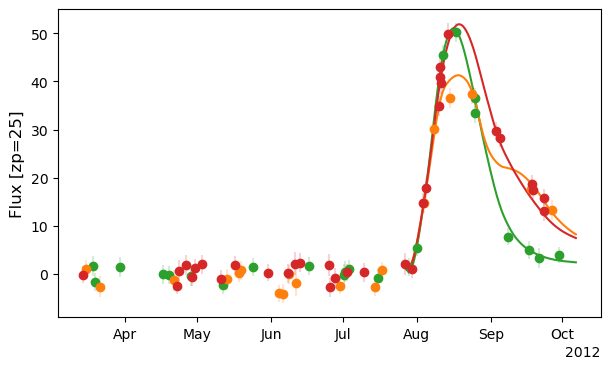

In [18]:
_ = dset.show_target_lightcurve(index=detected[212])

In [85]:
fixed = {"z": dset.targets.data.loc[detected]["z"]}

guess = {
    "t0": dset.targets.data.loc[detected]["t0"],
    "c": dset.targets.data.loc[detected]["c"],
    "x0": dset.targets.data.loc[detected]["x0"],
    "x1": dset.targets.data.loc[detected]["x1"],
}
bounds = {
    "t0": dset.targets.data.loc[detected]["t0"].apply(lambda x: [x-5, x+5]),
    "c": dset.targets.data.loc[detected]["c"].apply(lambda x: [-0.3, 1.0]),
    "x0": dset.targets.data.loc[detected]["x0"].apply(lambda x: [0, 0.1]),
    "x1": dset.targets.data.loc[detected]["x1"].apply(lambda x: [-4, 4]),
}

results, meta = dset.fit_lightcurves(
    source=sncosmo.Model("salt2"),
    index=detected,
    use_dask=False,
    fixedparams=fixed,
    guessparams=guess,
    bounds=bounds,
)

In [87]:
results

value     error        cov_t0        cov_x0        cov_x1  \
index                                                                        
61    z       0.165950       NaN           NaN           NaN           NaN   
      t0  56076.642355  0.000119  1.406037e-08 -8.320405e-15  3.406144e-10   
      x0      0.000141  0.000003 -8.320405e-15  8.518550e-12 -1.609167e-07   
      x1     -1.494876  0.173515  3.406144e-10 -1.609167e-07  3.012934e-02   
      c      -0.100651  0.016845  5.986491e-11 -4.064239e-08  7.499385e-04   
...                ...       ...           ...           ...           ...   
9976  z       0.175650       NaN           NaN           NaN           NaN   
      t0  56040.948513  0.020004  4.001741e-04  2.702059e-13 -1.271361e-08   
      x0      0.000044  0.000002  2.702059e-13  3.919417e-12 -2.269164e-07   
      x1     -0.518954  0.285869 -1.271361e-08 -2.269164e-07  8.186272e-02   
      c       0.366539  0.031626 -4.540617e-09 -5.675693e-08  2.304500e-03   

                 cov_c         truth  
index                                 
61    z            NaN       0.16595  
      t0  5.986491e-11  56075.347656  
      x0 -4.064239e-08       0.00014  
      x1  7.499385e-04         -1.77  
      c   2.838648e-04     -0.111124  
...                ...           ...  
9976  z            NaN       0.17565  
      t0 -4.540617e-09  56040.851562  
      x0 -5.675693e-08      0.000045  
      x1  2.304500e-03        -0.195  
      c   1.001014e-03      0.343443  

[1800 rows x 7 columns]

In [88]:
better_results = pandas.DataFrame(
    {
        col: np.array(results["value"].loc[map(lambda x: (x, col), detected)]-results["truth"].loc[map(lambda x: (x, col), detected)])
        for col in guess.keys()
    }
)

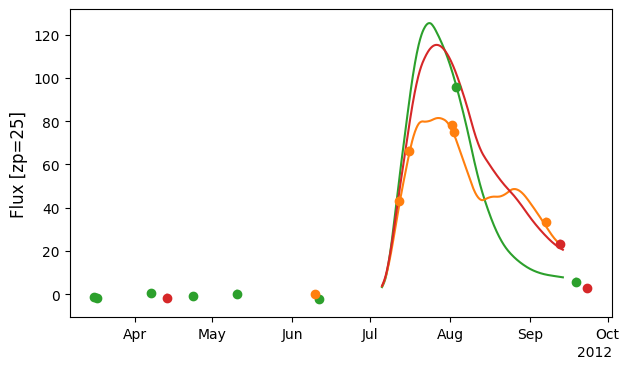

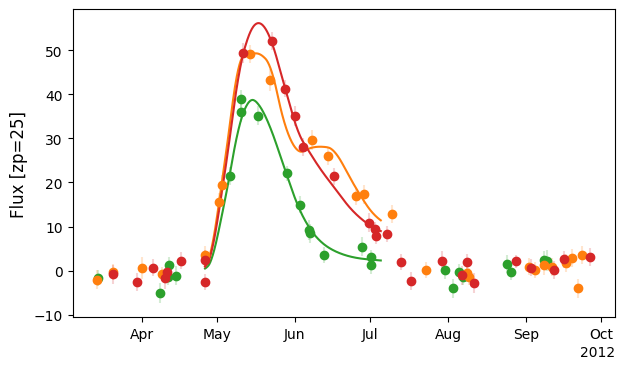

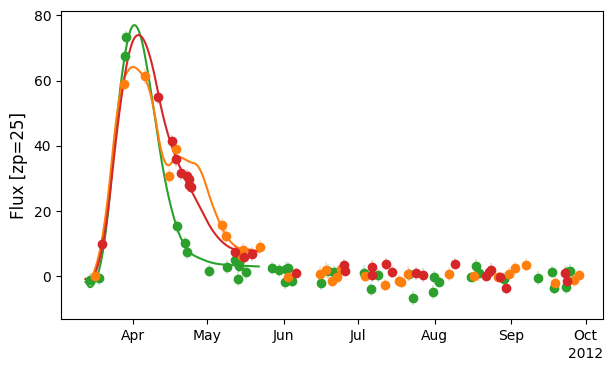

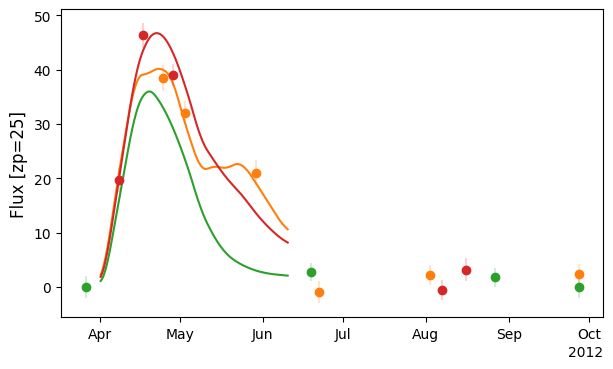

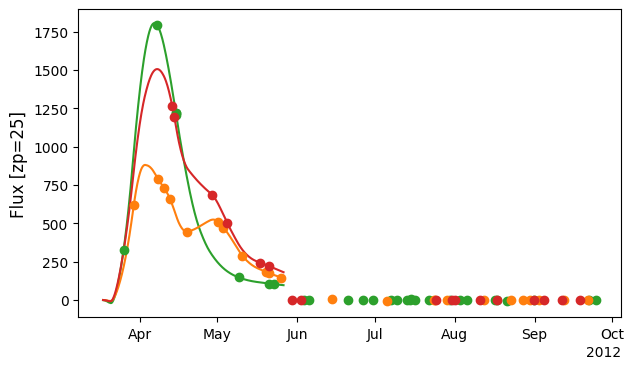

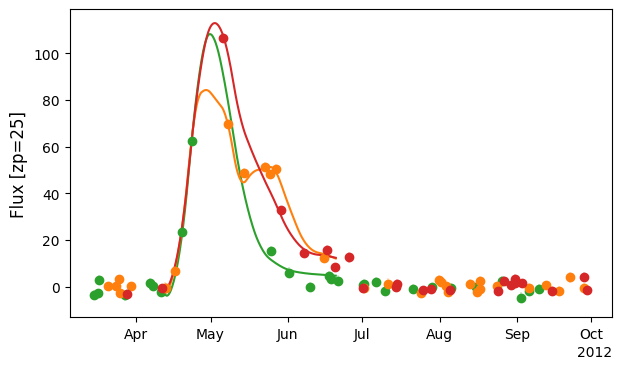

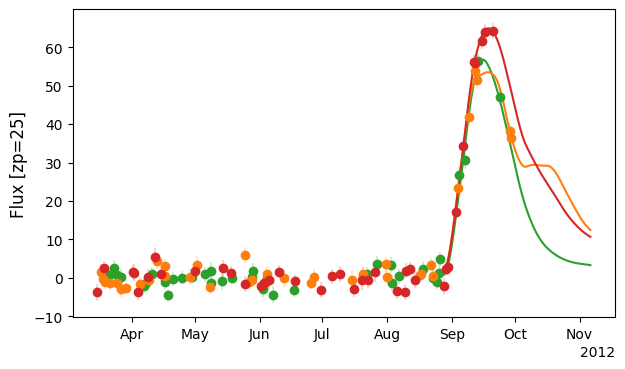

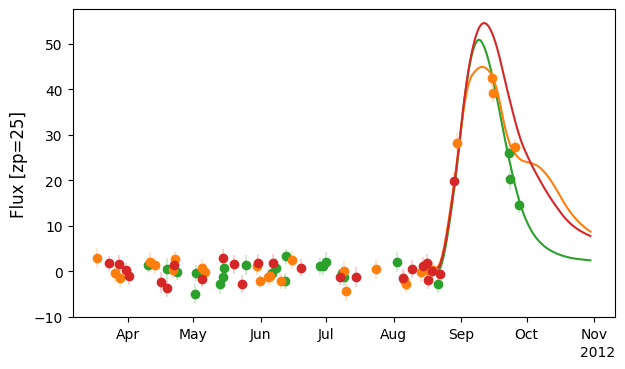

In [89]:
_ = dset.show_target_lightcurve(index=detected[better_results[better_results["t0"]==better_results['t0'].max()].index[0]])
_ = dset.show_target_lightcurve(index=detected[better_results[better_results["t0"]==better_results['t0'].min()].index[0]])

_ = dset.show_target_lightcurve(index=detected[better_results[better_results["c"]==better_results['c'].min()].index[0]])
_ = dset.show_target_lightcurve(index=detected[better_results[better_results["c"]==better_results['c'].max()].index[0]])

_ = dset.show_target_lightcurve(index=detected[better_results[better_results["x0"]==better_results['x0'].min()].index[0]])
_ = dset.show_target_lightcurve(index=detected[better_results[better_results["x0"]==better_results['x0'].max()].index[0]])

_ = dset.show_target_lightcurve(index=detected[better_results[better_results["x1"]==better_results['x1'].min()].index[0]])
_ = dset.show_target_lightcurve(index=detected[better_results[better_results["x1"]==better_results['x1'].max()].index[0]])

Text(0.5, 0.98, 'Erreur absolue sur les paramètres reconstruits')

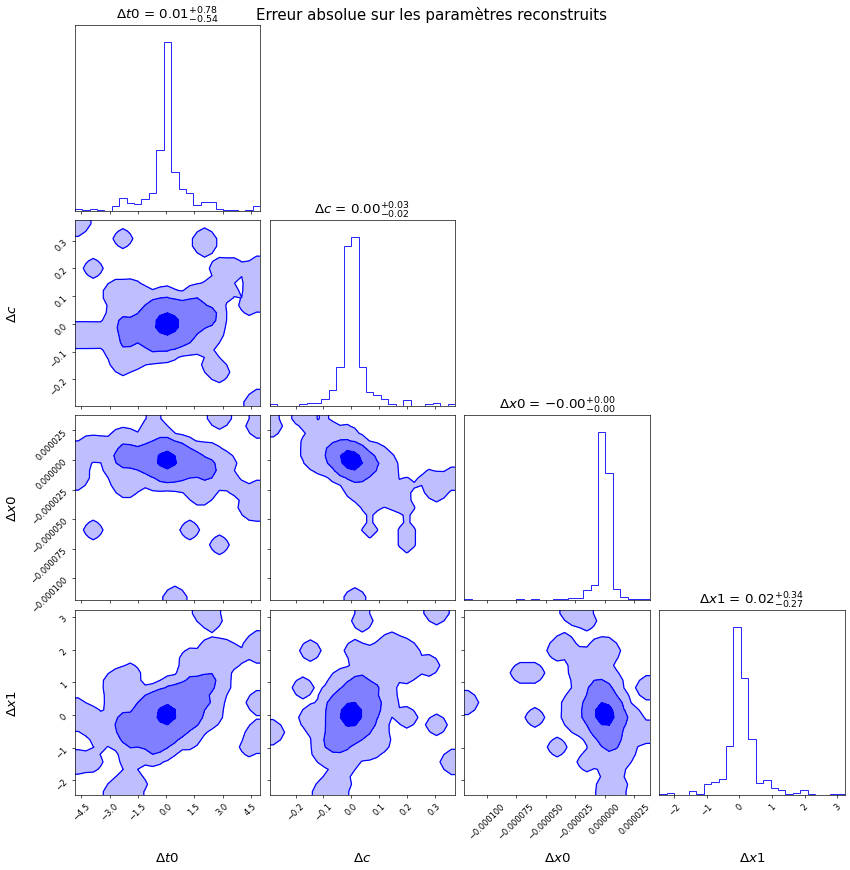

In [158]:
fig = plt.figure(figsize=(15,15),dpi=60)
_ = corner.corner(
    better_results,
    fig=fig,
    var_names=list(guess.keys()),
    show_titles=True,
    bins=25,
    smooth=0.9,
    label_kwargs=dict(fontsize=16),
    title_kwargs=dict(fontsize=16),
    color="b",
    levels=(1 - np.exp(-0.5), 1 - np.exp(-2), 1 - np.exp(-9 / 2.0)),
    plot_density=False,
    plot_datapoints=True,
    fill_contours=True,
    max_n_ticks=7,
    hist_kwargs=dict(density=True, color="b"),
    labels=list(map(lambda x : r"$\Delta "+x+r"$", guess.keys())),
    alpha=0.2,
)
fig.suptitle('Erreur absolue sur les paramètres reconstruits', fontsize=18)

# Uchuu tests

In [3]:
bgs_df = load_bgs(columns=['RA', 'DEC', 'Z', 'Z_COSMO', 'STATUS', 'V_PEAK', 'V_RMS'])

Found file ../../project/Projet-LPNHE/data/Uchuu.csv with columns Index(['dec', 'ra', 'z_cosmo', 'z', 'V_PEAK', 'V_RMS', 'in_desi'], dtype='object')


In [4]:
fig = corner_(bgs_df[::50], var_names=['ra','dec','z','z_cosmo', 'V_PEAK', 'V_RMS'])

In [5]:
plt.figure()
bgs_df[::100].plot.scatter('ra', 'dec', s=1, edgecolor=None, alpha=0.2)
plt.xlim(0,360)
plt.ylim(-25, 80)
plt.xlabel("RA (deg)")
plt.ylabel("Dec (deg)")

Text(0, 0.5, 'Dec (deg)')

In [6]:
snia = SNeIa()
data = snia.draw(size=10000, inplace=True)

In [7]:
mollweide_scatter(snia.data)

In [8]:
import pickle

with open('data/ztf_survey.pkl','rb') as file:
    survey = pickle.load(file)

In [9]:
survey.set_data(survey.data[survey.data['mjd'] < 58400])

In [45]:
data = survey.data.copy()

In [48]:
fieldids = survey.fieldids.names
fieldids

FrozenList(['fieldid', 'rcid'])

In [49]:
fieldgrouped = survey.data.groupby(fieldids)

In [51]:
data = fieldgrouped.size()

In [59]:
data

fieldid  rcid
245      0       105
         1       109
         2       109
         3       107
         4       109
                ... 
1880     59       12
         60       12
         61       12
         62       12
         63       12
Length: 58406, dtype: int64

In [ ]:
survey.show()

In [78]:
snia.data['t0'] = np.random.uniform(*survey.date_range,len(snia.data))

In [7]:
# footprint
from shapely import geometry

footprint = geometry.Point(0, 0).buffer(2)

# observing logs
from skysurvey.tools import utils

size = 10_000

data = {}
data["gain"] = 1
data["zp"] = 30
data["skynoise"] = np.random.normal(size=size, loc=200, scale=20)
data["mjd"] = np.random.uniform(56_000, 56_200, size=size)
data["band"] = np.random.choice(["ztfg", "ztfr", "ztfi"], size=size)

data["ra"], data["dec"] = utils.random_radec(
    size=size, ra_range=[200, 250], dec_range=[-20, 10]
)

# Load a GridSurvey
survey = skysurvey.Survey.from_pointings(data, footprint=footprint)

In [80]:
dset = skysurvey.DataSet.from_targets_and_survey(snia, survey)
dataset = dset.get_ndetection() > 5
detected = dataset[dataset].index

/global/homes/a/agillesl/.local/perlmutter/python-3.11/lib/python3.11/site-packages/ztffields/projection.py:157: UserWarning: cannot use dask_geopandas with MultiIndex fields dataframe
  warnings.warn("cannot use dask_geopandas with MultiIndex fields dataframe")
/global/homes/a/agillesl/.local/perlmutter/python-3.11/lib/python3.11/site-packages/skysurvey/dataset.py:154: FutureWarning: The behavior of pd.concat with len(keys) != len(objs) is deprecated. In a future version this will raise instead of truncating to the smaller of the two sequences
  data = pandas.concat(lightcurves, keys=fieldids # store fieldid


In [81]:
len(detected)

4496

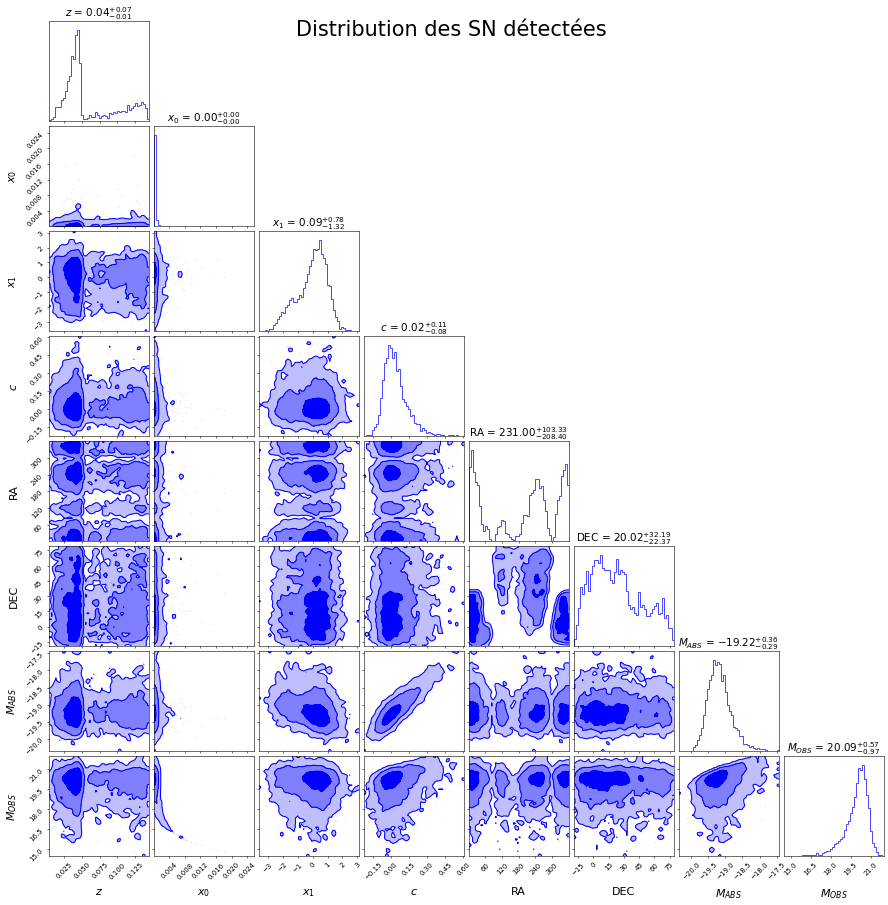

In [82]:
fig = corner_(dset.targets.data.loc[detected],
    var_names=["z", "x0", "x1", "c", "ra", "dec", "magabs", "magobs"],
    labels=[
        r"$z$",
        r"$x_0$",
        r"$x_1$",
        r"$c$",
        r"RA",
        r"DEC",
        r"$M_{ABS}$",
        r"$M_{OBS}$",
    ], title='Distribution des SN détectées')


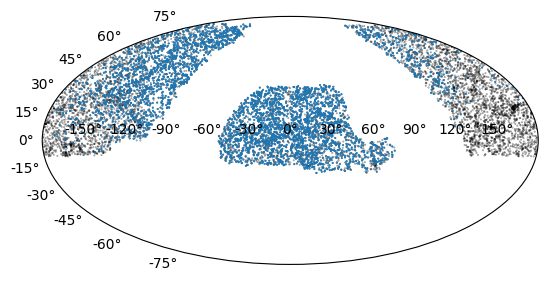

In [83]:
fig = plt.figure()
ax = fig.add_subplot(projection="mollweide")
ax.scatter(
    (dset.targets.data["ra"] - 360 * (dset.targets.data["ra"] > 180)) * np.pi / 180,
    dset.targets.data["dec"] * np.pi / 180,
    linestyle="",
    marker=".",
    s=0.5,
    c='k',
    alpha=0.5,
)
ax.scatter(
    (dset.targets.data.loc[detected]["ra"] - 360 * (dset.targets.data.loc[detected]["ra"] > 180)) * np.pi / 180,
    dset.targets.data.loc[detected]["dec"] * np.pi / 180,
    linestyle="",
    marker=".",
    s=1,
)
plt.savefig('../../../project/figures/Uchuu_scatter')

In [87]:
fixed = {"z": dset.targets.data.loc[detected]["z"]}

guess = {
    "t0": dset.targets.data.loc[detected]["t0"],
    "c": dset.targets.data.loc[detected]["c"],
    "x0": dset.targets.data.loc[detected]["x0"],
    "x1": dset.targets.data.loc[detected]["x1"],
}
bounds = {
    "t0": dset.targets.data.loc[detected]["t0"].apply(lambda x: [x-5, x+5]),
    "c": dset.targets.data.loc[detected]["c"].apply(lambda x: [-0.3, 1.0]),
    "x0": dset.targets.data.loc[detected]["x0"].apply(lambda x: [0, 0.1]),
    "x1": dset.targets.data.loc[detected]["x1"].apply(lambda x: [-4, 4]),
}

results, meta = dset.fit_lightcurves(
    source=sncosmo.Model("salt2"),
    index=detected[:400],
    use_dask=False,
    fixedparams=fixed,
    guessparams=guess,
    bounds=bounds,
)

100%|██████████| 400/400 [03:02<00:00,  2.20it/s]


In [103]:
results

value     error        cov_t0        cov_x0        cov_x1  \
index                                                                        
1     z       0.031152       NaN           NaN           NaN           NaN   
      t0  58351.524374  0.348482  1.216466e-01 -1.037290e-07 -2.561594e-02   
      x0      0.000060  0.000003 -1.037290e-07  7.074520e-12 -4.897262e-07   
      x1      0.050006  0.349021 -2.561594e-02 -4.897262e-07  1.221262e-01   
      c       0.166259  0.036383  5.945769e-04 -8.775734e-08  5.444224e-03   
...                ...       ...           ...           ...           ...   
919   z       0.042971       NaN           NaN           NaN           NaN   
      t0  58296.579556  6.854959  4.754773e+03 -2.813891e-03  1.066818e-01   
      x0      0.000543  0.000041 -2.813891e-03  1.668983e-09 -6.313936e-08   
      x1     -0.224055  0.002411  1.066818e-01 -6.313936e-08  5.810717e-06   
      c      -0.093809  0.000278  1.173124e-02 -6.943515e-09  2.631967e-07   

                 cov_c         truth  
index                                 
1     z            NaN      0.031152  
      t0  5.945769e-04  58352.617892  
      x0 -8.775734e-08      0.000059  
      x1  5.444224e-03         -0.42  
      c   1.325244e-03         0.144  
...                ...           ...  
919   z            NaN      0.042971  
      t0  1.173124e-02  58297.712925  
      x0 -6.943515e-09      0.000503  
      x1  2.631967e-07          0.93  
      c   7.723023e-08         -0.06  

[2000 rows x 7 columns]

In [104]:
better_results = pandas.DataFrame(
    {
        col: np.array(results["value"].loc[map(lambda x: (x, col), detected[:400])]-results["truth"].loc[map(lambda x: (x, col), detected[:400])])
        for col in guess.keys()
    }
)
better_results

,t0,c,x0,x1
0,-1.093518,0.022259,0.000001,0.470006
1,-0.526341,-0.013142,0.000003,-0.027025
2,0.190691,0.00883,-0.000006,0.096546
3,2.483887,0.060444,-0.000003,0.759315
4,1.372281,0.041256,-0.000019,1.338391
...,...,...,...,...
395,-0.743461,-0.009907,-0.000002,-0.3559
396,-0.423597,0.023683,-0.000004,-0.654511
397,0.094426,0.021963,-0.000013,0.203145
398,0.041464,0.020937,-0.000008,-0.065011


<Figure size 900x900 with 0 Axes>

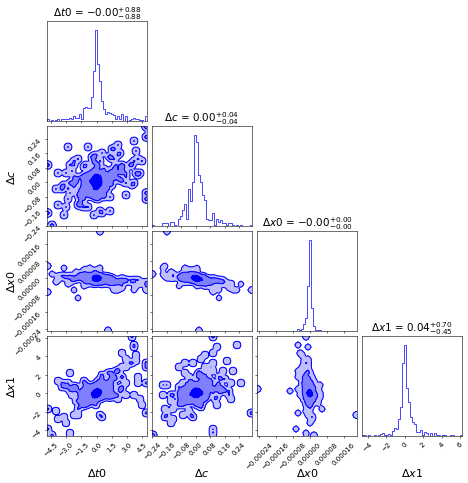

In [105]:
fig = plt.figure(figsize=(15,15),dpi=60)
_ = corner_(better_results,
    var_names=list(guess.keys()),
    labels=list(map(lambda x : r"$\Delta "+x+r"$", guess.keys())))
fig.suptitle('Erreur absolue sur les paramètres reconstruits', fontsize=18)
plt.savefig('../../../project/figures/Uchuu_reconstructed')

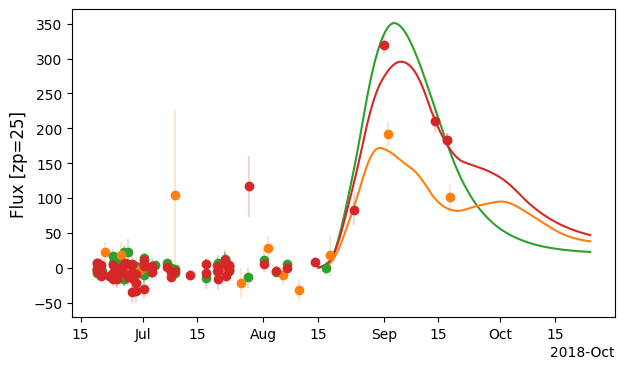

In [106]:
_ = dset.show_target_lightcurve(index=detected[better_results[better_results["x0"]==better_results['x0'].max()].index[0]])


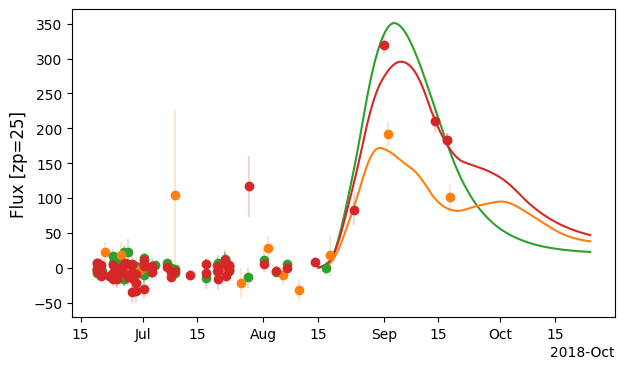

In [110]:
_ = dset.show_target_lightcurve(index=detected[better_results[better_results["x0"]==better_results['x0'].max()].index[0]])
